<a href="https://colab.research.google.com/github/luciaschmidtsantiago/probai-2025/blob/main/ProbAI2025_GeomProbModels_Uncertainty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
%matplotlib inline

import warnings
from tqdm import TqdmWarning
warnings.filterwarnings("ignore", category=TqdmWarning)

import numpy as np
import matplotlib.pyplot as plt
import torch

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

if torch.cuda.is_available():
    torch.set_default_device("cuda")
    device = torch.device("cuda")
else:
    torch.set_default_device("cpu")
    device = torch.device("cpu")
torch.set_default_dtype(torch.float64)
print("Using", device)

Using cuda


# PyTorch Fix

This fixes RandomSampler from `torch/utils/data/sampler.py` for cuda by removing the unnecessary `.numpy()`.

See related https://stackoverflow.com/questions/68621210/runtimeerror-expected-a-cuda-device-type-for-generator-but-found-cpu

In [6]:
from torch.utils.data import Sampler
from typing import (
    Iterator,
    Iterable,
    Optional,
    Sequence,
    List,
    TypeVar,
    Generic,
    Sized,
    Union,
)


class RandomSampler(Sampler[int]):
    r"""Samples elements randomly. If without replacement, then sample from a shuffled dataset.
    If with replacement, then user can specify :attr:`num_samples` to draw.

    Args:
        data_source (Dataset): dataset to sample from
        replacement (bool): samples are drawn on-demand with replacement if ``True``, default=``False``
        num_samples (int): number of samples to draw, default=`len(dataset)`.
        generator (Generator): Generator used in sampling.
    """

    data_source: Sized
    replacement: bool

    def __init__(
        self,
        data_source: Sized,
        replacement: bool = False,
        num_samples: Optional[int] = None,
        generator=None,
    ) -> None:
        self.data_source = data_source
        self.replacement = replacement
        self._num_samples = num_samples
        self.generator = generator

        if not isinstance(self.replacement, bool):
            raise TypeError(
                f"replacement should be a boolean value, but got replacement={self.replacement}"
            )

        if not isinstance(self.num_samples, int) or self.num_samples <= 0:
            raise ValueError(
                f"num_samples should be a positive integer value, but got num_samples={self.num_samples}"
            )

    @property
    def num_samples(self) -> int:
        # dataset size might change at runtime
        if self._num_samples is None:
            return len(self.data_source)
        return self._num_samples

    def __iter__(self) -> Iterator[int]:
        n = len(self.data_source)
        if self.generator is None:
            seed = int(torch.empty((), dtype=torch.int64).random_().item())
            generator = torch.Generator()
            generator.manual_seed(seed)
        else:
            generator = self.generator

        if self.replacement:
            for _ in range(self.num_samples // 32):
                # yield from map(int, torch.randint(high=n, size=(32,), dtype=torch.int64, generator=generator).numpy())
                yield from map(
                    int,
                    torch.randint(
                        high=n, size=(32,), dtype=torch.int64, generator=generator
                    ),
                )
            final_samples = torch.randint(
                high=n,
                size=(self.num_samples % 32,),
                dtype=torch.int64,
                generator=generator,
            )
            # yield from map(int, final_samples.numpy())
            yield from map(int, final_samples)
        else:
            for _ in range(self.num_samples // n):
                # yield from map(int, torch.randperm(n, generator=generator).numpy())
                yield from map(int, torch.randperm(n, generator=generator))
            # yield from map(int, torch.randperm(n, generator=generator)[:self.num_samples % n].numpy())
            yield from map(
                int, torch.randperm(n, generator=generator)[: self.num_samples % n]
            )

    def __len__(self) -> int:
        return self.num_samples

# Model Classes

## Deterministic Neural Network

In [7]:
class NNModel(nn.Module):
    def __init__(self, hidden_layer_size=100):
        super().__init__()
        self.fc1 = nn.Linear(1, hidden_layer_size)
        self.fc2 = nn.Linear(hidden_layer_size, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

### A Training Routine

In [8]:
def train(
    data,
    model,
    optimizer,
    criterion,
    epochs=100,
    batch_size=50,
    *,
    only_print_end_result=False,
):
    num_data = len(data)
    data_sampler = RandomSampler(
        data_source=data, generator=torch.Generator(device=device)
    )
    loader = DataLoader(
        data,
        batch_size=batch_size,
        sampler=data_sampler,
        generator=torch.Generator(device=device),
    )

    for epoch in range(epochs):
        running_loss = 0.0
        for i in range(2 * num_data // batch_size):
            batch_xs, batch_ys = next(iter(loader))
            batch_outputs = model(batch_xs)
            loss = criterion(batch_outputs, batch_ys)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        if (not only_print_end_result and (epoch % 10) == 0) or (
            only_print_end_result and epoch + 1 == epochs
        ):
            print(
                f"Epochs:{epoch + 1:5d} | "
                f"Batches per epoch: {i + 1:3d} | "
                f"Cur loss: {running_loss / (i + 1):.10f} | "
            )

# Prepare Data

In [9]:
NUM_DATA = 1000
NUM_TRAIN_DATA = 150
assert 2 * NUM_TRAIN_DATA < NUM_DATA
NUM_TEST_DATA = NUM_DATA - NUM_TRAIN_DATA

GT_FREQ = 8.5
OBS_NOISE_STD = 0.1


def gt(x):  # ground truth
    return torch.sin(GT_FREQ * x)


xs = torch.linspace(0, 1, NUM_DATA)[:, None]  # [NUM_DATA, 1]
train_indices = torch.arange(
    NUM_DATA // 2 - NUM_TRAIN_DATA, NUM_DATA // 2 + NUM_TRAIN_DATA
)  # [2*NUM_TRAIN_DATA]
train_indices = train_indices[
    torch.randperm(2 * NUM_TRAIN_DATA)[:NUM_TRAIN_DATA]
]  # [NUM_TRAIN_DATA]
xs_train = xs[train_indices]  # [NUM_TRAIN_DATA, 1]
ys_train = (
    gt(xs_train) + torch.randn(NUM_TRAIN_DATA, 1) * OBS_NOISE_STD
)  # [NUM_TRAIN_DATA, 1]

In [10]:
data_train = TensorDataset(xs_train, ys_train)

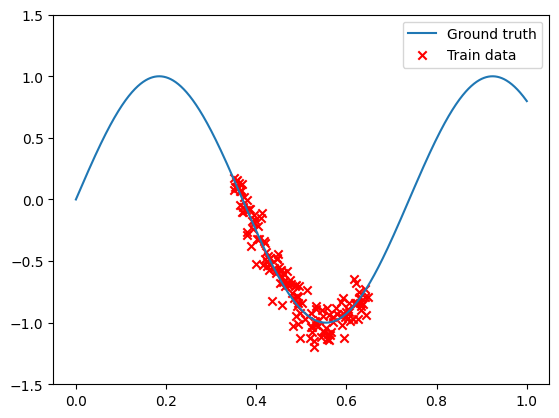

In [11]:
plt.plot(xs.detach().cpu(), gt(xs).detach().cpu(), label="Ground truth")
plt.scatter(
    xs_train.detach().cpu(),
    ys_train.detach().cpu(),
    marker="x",
    color="red",
    label="Train data",
)
plt.legend()
plt.ylim(-1.5, 1.5)
plt.show()

# Fitting a Deterministic Neural Network (Sanity Check)

In [12]:
nn_model = NNModel(100)

In [13]:
nn_optimizer = torch.optim.Adam(nn_model.parameters(), lr=0.01)
nn_criterion = nn.MSELoss()

nn_model.train()
train(data_train, nn_model, nn_optimizer, nn_criterion, 200, 50)
nn_model.eval();  # colon prevents from printing the model

Epochs:    1 | Batches per epoch:   6 | Cur loss: 0.1709452796 | 
Epochs:   11 | Batches per epoch:   6 | Cur loss: 0.0359849667 | 
Epochs:   21 | Batches per epoch:   6 | Cur loss: 0.0296033027 | 
Epochs:   31 | Batches per epoch:   6 | Cur loss: 0.0239978491 | 
Epochs:   41 | Batches per epoch:   6 | Cur loss: 0.0238016593 | 
Epochs:   51 | Batches per epoch:   6 | Cur loss: 0.0201962780 | 
Epochs:   61 | Batches per epoch:   6 | Cur loss: 0.0170776234 | 
Epochs:   71 | Batches per epoch:   6 | Cur loss: 0.0127834720 | 
Epochs:   81 | Batches per epoch:   6 | Cur loss: 0.0121318428 | 
Epochs:   91 | Batches per epoch:   6 | Cur loss: 0.0110062657 | 
Epochs:  101 | Batches per epoch:   6 | Cur loss: 0.0126781316 | 
Epochs:  111 | Batches per epoch:   6 | Cur loss: 0.0121233231 | 
Epochs:  121 | Batches per epoch:   6 | Cur loss: 0.0140249182 | 
Epochs:  131 | Batches per epoch:   6 | Cur loss: 0.0129333953 | 
Epochs:  141 | Batches per epoch:   6 | Cur loss: 0.0114045903 | 
Epochs:  1

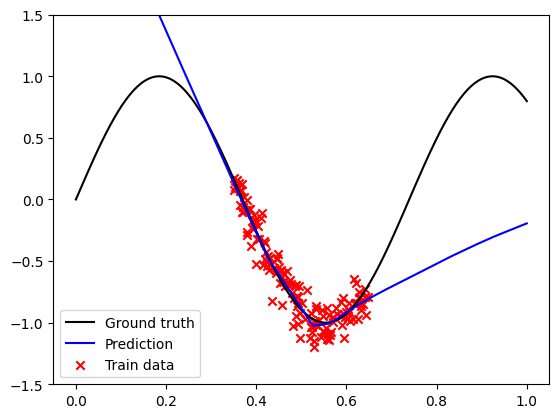

In [14]:
with torch.no_grad():
    plt.plot(
        xs.detach().cpu(), gt(xs).detach().cpu(), color="black", label="Ground truth"
    )
    plt.plot(
        xs.detach().cpu(), nn_model(xs).detach().cpu(), color="blue", label="Prediction"
    )
    plt.scatter(
        xs_train.detach().cpu(),
        ys_train.detach().cpu(),
        marker="x",
        color="red",
        label="Train data",
    )
    plt.legend()
    plt.ylim(-1.5, 1.5)
    plt.show()

In [15]:
# Delete stuff to avoid typos in the future cells
del nn_model
del nn_optimizer
del nn_criterion

# Practice: Fitting an Ensemble of Neural Networks

In [18]:
NUM_MODELS = 50
predictions = []
for i in range(NUM_MODELS):
    model = NNModel(100)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.MSELoss()

    model.train()
    train(data_train, model, optimizer, criterion, 200, 50, only_print_end_result=True)
    prediction = model(xs).detach().cpu()
    predictions.append(prediction)

predictions_array = np.stack(predictions, axis=1)

# Task: train `NUM_MODELS` instances of `NNModel(100)`.
# Tip: use <=100 epochs and <=50 batch size to make it run quickly, use
# `train` with `only_print_end_result=True` to avoid excessive printing.

Epochs:  200 | Batches per epoch:   6 | Cur loss: 0.0110024585 | 
Epochs:  200 | Batches per epoch:   6 | Cur loss: 0.0098309756 | 
Epochs:  200 | Batches per epoch:   6 | Cur loss: 0.0099564995 | 
Epochs:  200 | Batches per epoch:   6 | Cur loss: 0.0097195561 | 
Epochs:  200 | Batches per epoch:   6 | Cur loss: 0.0098795538 | 
Epochs:  200 | Batches per epoch:   6 | Cur loss: 0.0101460204 | 
Epochs:  200 | Batches per epoch:   6 | Cur loss: 0.0099115634 | 
Epochs:  200 | Batches per epoch:   6 | Cur loss: 0.0100816631 | 
Epochs:  200 | Batches per epoch:   6 | Cur loss: 0.0097325758 | 
Epochs:  200 | Batches per epoch:   6 | Cur loss: 0.0098319948 | 
Epochs:  200 | Batches per epoch:   6 | Cur loss: 0.0099965953 | 
Epochs:  200 | Batches per epoch:   6 | Cur loss: 0.0102289923 | 
Epochs:  200 | Batches per epoch:   6 | Cur loss: 0.0097758293 | 
Epochs:  200 | Batches per epoch:   6 | Cur loss: 0.0101235686 | 
Epochs:  200 | Batches per epoch:   6 | Cur loss: 0.0097993491 | 
Epochs:  2

In [28]:
# Task: compute the prediction (mean over preditctions of individual neural networks)
ens_mean =  np.mean(predictions_array, axis=1)
# Task: compute the uncertainty (standard deviation of preditctions of individual neural networks)
ens_std =   np.std(predictions_array, axis=1)
ens_lower = ens_mean - 2 * ens_std
ens_upper = ens_mean + 2 * ens_std

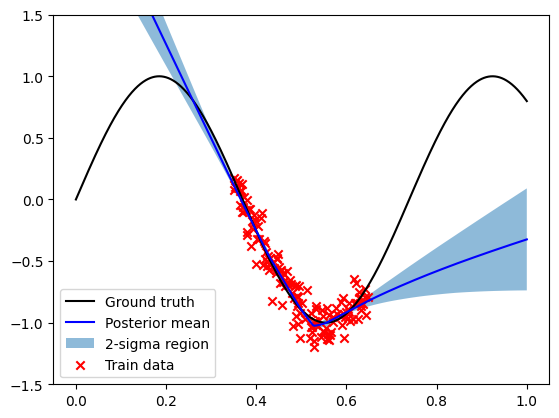

In [30]:
plt.plot(xs.detach().cpu(), gt(xs).detach().cpu(), color="black", label="Ground truth")
plt.plot(xs.detach().cpu(), ens_mean, color="blue", label="Posterior mean")
plt.fill_between(
    xs.detach().cpu().flatten(),
    ens_lower.flatten(),
    ens_upper.flatten(),
    alpha=0.5,
    label="2-sigma region",
)
plt.scatter(
    xs_train.detach().cpu(),
    ys_train.detach().cpu(),
    marker="x",
    color="red",
    label="Train data",
)
plt.legend()
plt.ylim(-1.5, 1.5)
plt.show()